In [1]:
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
import numpy as np
import codecs
import time
import re
import os
from IPython.display import display, HTML
from difflib import SequenceMatcher
import math
import Levenshtein
import shutil

import importlib.util
spec = importlib.util.spec_from_file_location("module.name","sanskrit_transcoder/transcoder.py")
transcoder = importlib.util.module_from_spec(spec)
spec.loader.exec_module(transcoder)
transcoder.transcoder_set_dir('sanskrit_transcoder/data/transcoder');

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', -1)

In [94]:
import matplotlib.pyplot as plt
import networkx as nx

In [95]:
s = pd.read_csv("all_sandhi.txt",encoding = 'utf-8' ,sep = ',')
s.loc[(s['c1'] == 'a') & (s['c2'] == 'i')]


,id,c1,c2,c3
2,2,a,i,e


In [96]:
def printlines(fname) :
    with open(fname,encoding = 'utf-8' ,mode ='r') as fr :
        for line in fr.readlines() :
            print(line)
            
    return 

def getline(fname,tag = 'input line : ') :
    with open(fname,encoding = 'utf-8' ,mode ='r') as fr :
        for line in fr.readlines() :
            if(line.startswith(tag)) :
                l = line[len(tag):-1]
    return l

def getconvertedline(fname) :
    with open(fname,encoding = 'utf-8' ,mode ='r') as fr :
        for line in fr.readlines() :
            if(line.startswith("converted line : ")) :
                l = line[17:-1]
               
    return l

def getcovertedchar(fname) :
    with open(fname,encoding = 'utf-8' ,mode ='r') as fr :
        for line in fr.readlines() :
            if(line.startswith("converted line char :")) :
                l = line[21:-1].split(',')
               
    return l


def fetched_data(fname) :
    fd = pd.read_csv(fname,encoding = 'utf-8' ,sep = ',')
    return fd


def dependency_structure(fname):
    ds = pd.read_csv(fname,encoding = 'utf-8' ,sep = ',')
    return ds


def inputline_(fname) :
    with open(fname,encoding = 'utf-8' ,mode ='r') as fr :
        for line in fr.readlines() :
            if(line.startswith("input line : ")):
                return line[13:-1]
            
            
def conflicts_dataframe(fname) :
    cd = pd.read_csv(fname,encoding = 'utf-8' ,sep = ',')
    return cd

def originalline_(fname) :
    with open(fname,encoding = 'utf-8' ,mode ='r') as fr :
        for line in fr.readlines() :
            if(line.startswith("SENT: ")):
                return line[6:-1]


In [8]:
def mathchwords(depword,inputword) :
    word1 = depword
    word2 = inputword
    
    check = False
    l1 = len(word1)
    l2 = len(word2)
    
    if word2 == word1 :
        check = True
        return check
    if (word2[:-1] == word1[:-1]) and (word1[-1].lower()==word2[-1].lower()=='m'):
        check = True
        return check  

    if word1[:-1] == word2[:-1] :
        if (word1[-1] == 'x')and (word2[-1]=='w') :
            check = True
            return check
        
    if (word1 == 'banXo') and (word2 == 'banXaH') :
        check = True
        return check
    if (word1 == 'sparSo') and (word2 == 'sparSaH') :
        check = True
        return check
    if (word1 == 'prAg') and (word2 == 'prAq') :
        check = True
        return check
    
    if re.findall('\+',word1) :
        word3 = re.sub('\+','',word1)
        if not word3[-1] == 'i' :
            if word2==word3 :
                check = True
                return check
            else :
                if (word3==word2) or (word3[:-1]==word2):
                    check = True
                    return check
    if (word1[:-1]==word2) and (word1[-1] == 'i'):
        check = True
        return check
    
    if(l1==l2) :
        word3 = word1
        for j in range(0,l1) :
            if not word1[j] == word2[j] :
                if word1[j] == 'M' :
                    if word2[j] == 'n'or word2[j] == 'm' or word2[j] == 'f' or word2[j] == 'F':
                        word3=word3[:j]+word2[j]+word3[j+1:]
        if word2 == word3 :
            check = True
            return check
    
    return False

In [98]:
path1 = 'workdata/lines_submit/adding/phase3/'
path2 = 'workdata/lines_submit/adding/checking/'
path3 = 'workdata/lines_submit/adding/dfconflicts/'
fnames1 = os.listdir(path1)
len(fnames1)

2948

In [11]:
for fname in fnames1[0:10] :
    print(inputline_(path1+fname+'/input_line.txt'))

rAmasya BAryA sIwA wasya anujaH lakRmaNaH ca rAmeNa saha vanam gacCawaH
sIwA lakRmaNaH ca wAn namawaH
vqkReRu KagAH vasanwi
SAswrANAM wawwvaM prajFaH boXawi
vIrayoH yuxXaM Bavawi
gireH SiKarAw vqRaH pawawi
gajAnAM yUWaM carawi
grIRme sUryasya prakASaH caNdaH Bavawi
qRINAM vacanaM pramANam Bavawi
kavayaH lokeRu vIrANAM parAkramAn praWayanwi


In [2]:
inputline = 'grIRme sUryasya prakASaH caNdaH Bavawi bavAwi'


In [3]:
problem = []
pbwords = []
s_d = inputline

s_c = s_d.replace(" ","+")
urlname = ("http://sanskrit.inria.fr/cgi-bin/SKT/sktgraph?lex=SH&st=t&us=f&cp=t&text=" +
           s_c + "&t=WX&topic=&mode=g&corpmode=&corpdir=&sentno=")

print(urlname)
page = requests.get(urlname)
soup = bs(page.text, 'html.parser')
#     soup.prettify()
table = soup.table
tablebody = table.find('table',{'class' : 'center'})
t = pd.DataFrame(columns = ['id','level','color_class','position','chunk_no','word','lemma','pre_verb','morph','colspan','wordlenth','aux_inf'])

i = 0
id_= 0
if not(tablebody) :      #### wronginputs

    print('no table body of given inputline')
    
    
for child in tablebody.children:
    if(child.name == 'tr') :
        if i< 1 : 
            linechar = []
            c=0
            for char in child.children :
                linechar.append(char.string)
                c += 1
            i+=1
            line = "".join(linechar)
            linechunks = line.split("\xa0")
            continue
        position_ = 0
        j =0
        for wordtable in child.children:
#             if(j < 20 ) :
#                 j += 1
#                 continue
            c= 0
            for ch in linechar[0:position_] :
                if(re.match('\xa0',ch)) : 
                    c+=1
            if(wordtable.contents):
                color_ = wordtable.table.get('class')[0]
                colspan_= wordtable.get('colspan')
                word_ = wordtable.table.tr.td.string
                onclickdatas_ = wordtable.table.tr.td.get('onclick')
                for onclickdata_ in onclickdatas_.split("<br>") :
                    morphslist_ = re.findall(r'{ (.*?) }',onclickdata_)  #.split(' | ')
                    ldata = str(re.search(r'{.*?}\[(.*)\]',onclickdata_).group(1))
                    ldata = str(re.sub(r'</?a.*?>|</?i>',"",ldata))

                    lemmadata = ldata.split(" ")
                    if len(lemmadata) >1 :
                        auxi_ = " ".join(lemmadata[1:])
                    else :
                        auxi_ = ""
                    lemmas_ = "".join(lemmadata[0])
                    lemmalists_ = lemmas_.split("-")
                    if(len(lemmalists_) > 1) :
                        preverb_ = ",".join(lemmalists_[0:(len(lemmalists_)-1)])
                        lemmalist_ = "".join(lemmalists_[-1:]).split("_")
                    else :
                        preverb_ = ""
                        lemmalist_ = "".join(lemmalists_[0]).split("_")
                    if(len(lemmalist_) > 1):
                        auxi_ =auxi_ + " sence of lemma = " + "".join(lemmalist_[1:(len(lemmalist_))])
                        lemma_ = "".join(lemmalist_[0])
                    else : 
                        lemma_ = "".join(lemmalist_[0])             
                    morphs_ = str(morphslist_[0])               
                    for morph_ in morphs_.split(" | ") : 
                        t.loc[id_] = [id_,i,color_,position_,c+1,word_,lemma_,preverb_,morph_,int(colspan_),len(word_),auxi_]
                        if(re.match(r'grey_back',color_)) :
                            if not (word_ == 'pop') :
                                problem.append(id_)
                            else :
                                id_ = id_ - 1
                        id_ += 1    


                position_ += int(colspan_)
    #                 break
            else : 
                position_ += 1

#         break

        i = i+1

# print("input line : " + inputline + "\n")
# print("converted line : "+line + "\n")
# print("converted line char :" + ",".join(linechar) + "\n")



t

http://sanskrit.inria.fr/cgi-bin/SKT/sktgraph?lex=SH&st=t&us=f&cp=t&text=grIRme+sUryasya+prakASaH+caNdaH+Bavawi+bavAwi&t=WX&topic=&mode=g&corpmode=&corpdir=&sentno=


,id,level,color_class,position,chunk_no,word,lemma,pre_verb,morph,colspan,wordlenth,aux_inf
0,0,1,deep_sky_back,0,1,grīṣme,grīṣma,,loc. sg. m.,6,6,
1,1,1,deep_sky_back,7,2,sūryasya,sūrya,,g. sg. m.,8,8,
2,2,1,deep_sky_back,16,3,prakāśaḥ,prakāśa,,nom. sg. m.,8,8,
3,3,1,deep_sky_back,25,4,caṇḍaḥ,caṇḍa,,nom. sg. m.,6,6,
4,4,1,deep_sky_back,32,5,bhavati,bhavat,,loc. sg. m.,6,7,sence of lemma = 2
5,5,1,grey_back,39,6,bavāti,bavāti,,?,6,6,
6,6,2,deep_sky_back,7,2,sūrī,sūri,,acc. du. m.,4,4,
7,7,2,deep_sky_back,7,2,sūrī,sūri,,nom. du. m.,4,4,
8,8,2,light_blue_back,11,2,asya,idam,,g. sg. n.,4,4,
9,9,2,light_blue_back,11,2,asya,idam,,g. sg. m.,4,4,


In [4]:
line1=line
chunkwords = line1.split("\xa0")

df = t


cf = pd.DataFrame(columns=[str(j) for j in df.id.values])
for i in df.id.values :
    cf.loc[i] = -1


df['word_slp1'] = df['word']
df['word_wx'] = df['word']
for i in df.index:
    df.loc[i,'word_slp1']   =  transcoder.transcoder_processString(df.loc[i,'word'],'roman','slp1')  ##transcoder
    df.loc[i,'word_wx']   =  transcoder.transcoder_processString(df.loc[i,'word_slp1'],'slp1','wx') 
df['sandhi_indexs'] = ""
df['sandhi_words'] = ""
for i in df.index : 
    word1 = df.loc[i,'word_slp1']
    chunkno = df.loc[i,'chunk_no']
    position1 =  df.loc[i,'position']
    level = df.loc[i,'level']
    color1 = df.loc[i,'color_class']
    clspan1 = int(df.loc[i,'colspan'])
    chunkword = transcoder.transcoder_processString(chunkwords[chunkno-1],'roman','slp1')   ## transcoder
    df1 = df.loc[(df['chunk_no'] == chunkno) ]
    for j in df1.index :
        if i == j :
            cf.loc[i,str(j)] = 3
            cf.loc[j,str(i)] = 3 
            continue
        if (cf.loc[i,str(j)] != 1) and (cf.loc[i,str(j)] != 0) and (cf.loc[i,str(j)] != 3):
            cf.loc[i,str(j)] = 2
        position2 = df1.loc[j,'position']
        color2 = df.loc[i,'color_class']
        word2 = df1.loc[j,'word_slp1']
        word3 = df1.loc[j,'word']
        if(position2 == position1 + clspan1-1) and (clspan1!=1):
            if((color1=='yellow_back') and (color2=='carmin_back'))  :    ## check color ,iic and verb
                continue
            if((color2=='yellow_back') and (color1=='carmin_back'))  :    ## check color
                continue
          
            
            if(len(s.loc[(s['c1']==word1[-1:] )& (s['c2']==word2[:1])])):

                x=s.loc[(s['c1']==word1[-1:] )& (s['c2']==word2[:1])]
                for c3 in x['c3']:
                    mergeword = word1[:-1] + c3 + word2[1:2]
#                             print(mergeword+"---"+chunkword)
                    if(re.findall(mergeword,chunkword)):               ## checking  mergedword(spl1) in chunkword
                        df.loc[i,'sandhi_indexs'] += str(j)+", "
                        df.loc[i,'sandhi_words'] += word3+"("+word2+"), "
                        cf.loc[i,str(j)] = 1                             ## merge pssible so change conflict
                        cf.loc[j,str(i)] = 1   
                        print(word1,word2,i,j)
                        break
            elif(word1[-1:]=='H'):
                if(len(s.loc[(s['c1']==word1[-2:] )& (s['c2']==word2[:1])])):

                    x=s.loc[(s['c1']==word1[-2:] )& (s['c2']==word2[:1])]
                    for c3 in x['c3']:
                        mergeword = word1[:-1] + c3 + word2[1:2]
                        if(re.findall(mergeword,chunkword)):          ## checking  mergedword(spl1) in chunkword   
                            df.loc[i,'sandhi_indexs'] += str(j)+", "
                            df.loc[i,'sandhi_words'] += word3+"("+word2+"), "
                            cf.loc[i,str(j)] = 1                        ## merge pssible so change conflict
                            cf.loc[j,str(i)] = 1 
                            print(word1,word2,i,j)
                            break
        elif(position2 > position1 + clspan1-1) :
            cf.loc[i,str(j)] = 0
            cf.loc[j,str(i)] = 0

#         df.to_csv(name+fname+"/dataframe_withsandhi.txt" ,encoding = 'utf-8' , sep=',',index = False,mode = 'w' )

## for conflict finding 0 = no conflict,1=possible merge,2=conflict ,3=itself

for i in df.index :
    chunkno = df.loc[i,'chunk_no']
    position1 =  df.loc[i,'position']
    level = df.loc[i,'level']
    color1 = df.loc[i,'color_class']
    clspan1 = df.loc[i,'colspan']
    df1 = df.loc[(df['chunk_no'] != chunkno)]
    for j in df1.index :
        cf.loc[i,str(j)] = 0


#         cf.to_csv(name+fname+"/conflicts.csv" ,encoding = 'utf-8' , sep=',',index = False,mode = 'w' )               
                        
#         break
#     break
# print(name+fname+"/dataframe_withsandhi.txt")

In [5]:
cf

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,3,0,0,0,0,2,2,2,2,0,2,0,0,0
2,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,3,0,0,0,0,0,2,0,2,2,2
5,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0
6,0,2,0,0,0,0,3,2,0,0,0,0,0,0,0
7,0,2,0,0,0,0,2,3,0,0,0,0,0,0,0
8,0,2,0,0,0,0,0,0,3,2,0,2,0,0,0
9,0,2,0,0,0,0,0,0,2,3,0,2,0,0,0


In [6]:
fd = df
cd = cf


In [7]:
cd['id'] = cd.index
colnames = cd.columns.tolist()
colnames = colnames[-1:] + colnames[:-1]
cd = cd[colnames]

In [8]:
x = [cd.index.values[0]]
for i in x : 
    y = cd.loc[cd[str(i)]==2].index.values
    z = cd.loc[(cd[str(i)]==0) | (cd[str(i)]==1)].index.values
    cd = cd.drop(y)
    cd =cd.drop(i)
    del(cd[str(i)])
    for j in y :
        del(cd[str(j)])
    if any(z) :
        x.append(z[0])
    else :
        break


fd.index = fd.id
f = fd.loc[x] 
f['endp'] = f['position']+f['colspan']
f = f.sort_values('endp')
endp = f.loc[f.index[0],'endp'] 
for i in f.index[1:] :
    pos = f.loc[i,'position']
    if (pos == endp) or(pos == endp+1) or (pos == endp-1) :
#             print(i,'ok')
        i
    else :
        print(i,'notok')
        break
    endp = f.loc[i,'endp']
    
print(' '.join(f.word.values),'---',line1)

grīṣme sūryasya prakāśaḥ caṇḍaḥ bhavati bavāti --- grīṣme sūryasya prakāśaḥ caṇḍaḥ bhavati bavāti 


In [9]:
cd = cf
fd = df

In [10]:
cd.index = cd.id
    
# os.makedirs(path2+fname+'/', exist_ok=True)

cols = fd.columns 
G = nx.DiGraph()
for i in fd.index :
    id_ = fd.loc[i,'id']
    G.add_node(id_)
    for col in cols :
        if not  str(fd.loc[i,col]) == 'nan':
            if col in ['id','position','level','chunk_no','colspan','wordlenth'] :
                G.nodes[id_][col] = int(fd.loc[i,col])
            else :
                G.nodes[id_][col] = str(fd.loc[i,col])
        else :
            G.nodes[id_][col] = ''

for i in fd.index :
    id1 = fd.loc[i,'id']
    for j in fd.index:
        id2 = fd.loc[j,'id']
        conflict = cd.loc[id1,str(id2)]
        if conflict == 0 or conflict == 1:
            G.add_edge(id1,id2)
            if conflict == 0 :
                G[id1][id2]['conflict'] = 'adj'
            else :
                G[id1][id2]['conflict'] = 'merge'



NameError: name 'nx' is not defined

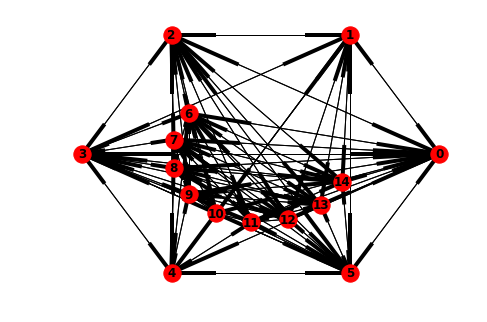

In [130]:


nx.draw_shell(G, nlist=[fd.id.values, x], with_labels=True, font_weight='bold')
plt.show()

In [132]:
fd

,id,level,color_class,position,chunk_no,word,lemma,pre_verb,morph,colspan,wordlenth,aux_inf,word_slp1,word_wx,sandhi_indexs,sandhi_words
id,,,,,,,,,,,,,,,,
0,0,1,deep_sky_back,0,1,grīṣme,grīṣma,,loc. sg. m.,6,6,,grIzme,grIRme,,
1,1,1,deep_sky_back,7,2,sūryasya,sūrya,,g. sg. m.,8,8,,sUryasya,sUryasya,,
2,2,1,deep_sky_back,16,3,prakāśaḥ,prakāśa,,nom. sg. m.,8,8,,prakASaH,prakASaH,,
3,3,1,deep_sky_back,25,4,caṇḍaḥ,caṇḍa,,nom. sg. m.,6,6,,caRqaH,caNdaH,,
4,4,1,deep_sky_back,32,5,bhavati,bhavat,,loc. sg. m.,6,7,sence of lemma = 2,Bavati,Bavawi,,
5,5,1,grey_back,39,6,bavāti,bavāti,,?,6,6,,bavAti,bavAwi,,
6,6,2,deep_sky_back,7,2,sūrī,sūri,,acc. du. m.,4,4,,sUrI,sUrI,,
7,7,2,deep_sky_back,7,2,sūrī,sūri,,nom. du. m.,4,4,,sUrI,sUrI,,
8,8,2,light_blue_back,11,2,asya,idam,,g. sg. n.,4,4,,asya,asya,,


In [68]:
# to remove nodes 
# G.remove_nodes_from(e)

df.to_csv(path2+'dataframe.csv' ,encoding = 'utf-8' , sep=',',index = False,mode = 'w' )
cf.to_csv(path2+'conflicts.csv' ,encoding = 'utf-8' , sep=',',index = False,mode = 'w' )
nx.write_graphml(G, path2+'Graph.graphml')

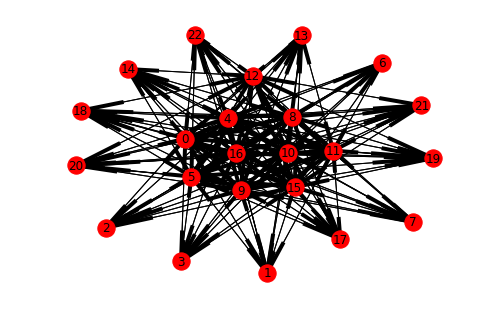

In [92]:
fd= pd.read_csv(path2+'dataframe.csv',encoding = 'utf-8' ,sep = ',')
cd= pd.read_csv(path2+'conflicts.csv',encoding = 'utf-8' ,sep = ',')
G = nx.read_graphml(path2+'Graph.graphml')

# pos=nx.spring_layout(G)
# nx.draw_shell(G, nlist=[fd.id.values, x], with_labels=True, font_weight='bold')

nx.draw(G,with_labels=True)
plt.show()

In [83]:
x

[0, 1, 4]

In [ ]:
# for fname in fnames1 :
#     df= fetched_data(path1+fname+'/dataframe.txt')
#     os.makedirs(path3+fname+'/', exist_ok=True)
#     line1 = getconvertedline(path1+fname+'/input_line.txt')
    
#     chunkwords = line1.split("\xa0")



#     cf = pd.DataFrame(columns=[str(j) for j in df.id.values])
#     for i in df.id.values :
#         cf.loc[i] = -1


#     df['word_slp1'] = df['word']
#     df['word_wx'] = df['word']
#     for i in df.index:
#         df.loc[i,'word_slp1']   =  transcoder.transcoder_processString(df.loc[i,'word'],'roman','slp1')  ##transcoder
#         df.loc[i,'word_wx']   =  transcoder.transcoder_processString(df.loc[i,'word_slp1'],'slp1','wx') 
#     df['sandhi_indexs'] = ""
#     df['sandhi_words'] = ""
#     for i in df.index : 
#         word1 = df.loc[i,'word_slp1']
#         chunkno = df.loc[i,'chunk_no']
#         position1 =  df.loc[i,'position']
#         level = df.loc[i,'level']
#         color1 = df.loc[i,'color_class']
#         clspan1 = int(df.loc[i,'colspan'])
#         chunkword = transcoder.transcoder_processString(chunkwords[chunkno-1],'roman','slp1')   ## transcoder
#         df1 = df.loc[(df['chunk_no'] == chunkno) ]
#         for j in df1.index :
#             if i == j :
#                 cf.loc[i,str(j)] = 3
#                 cf.loc[j,str(i)] = 3 
#                 continue
#             if (cf.loc[i,str(j)] != 1) and (cf.loc[i,str(j)] != 0) and (cf.loc[i,str(j)] != 3):
#                 cf.loc[i,str(j)] = 2
#             position2 = df1.loc[j,'position']
#             color2 = df.loc[i,'color_class']
#             word2 = df1.loc[j,'word_slp1']
#             word3 = df1.loc[j,'word']
#             if(position2 == position1 + clspan1-1) and (clspan1!=1):
#                 if((color1=='yellow_back') and (color2=='carmin_back'))  :    ## check color ,iic and verb
#                     continue
#                 if((color2=='yellow_back') and (color1=='carmin_back'))  :    ## check color
#                     continue

#                 if(len(s.loc[(s['c1']==word1[-1:] )& (s['c2']==word2[:1])])):

#                     x=s.loc[(s['c1']==word1[-1:] )& (s['c2']==word2[:1])]
#                     for c3 in x['c3']:
#                         mergeword = word1[:-1] + c3 + word2[1:2]
#     #                             print(mergeword+"---"+chunkword)
#                         if(re.findall(mergeword,chunkword)):               ## checking  mergedword(spl1) in chunkword
#                             df.loc[i,'sandhi_indexs'] += str(j)+", "
#                             df.loc[i,'sandhi_words'] += word3+"("+word2+"), "
#                             cf.loc[i,str(j)] = 1                             ## merge pssible so change conflict
#                             cf.loc[j,str(i)] = 1   
# #                             print(word1,word2,i,j)
#                             break
#                 elif(word1[-1:]=='H'):
#                     if(len(s.loc[(s['c1']==word1[-2:] )& (s['c2']==word2[:1])])):

#                         x=s.loc[(s['c1']==word1[-2:] )& (s['c2']==word2[:1])]
#                         for c3 in x['c3']:
#                             mergeword = word1[:-1] + c3 + word2[1:2]
#                             if(re.findall(mergeword,chunkword)):          ## checking  mergedword(spl1) in chunkword   
#                                 df.loc[i,'sandhi_indexs'] += str(j)+", "
#                                 df.loc[i,'sandhi_words'] += word3+"("+word2+"), "
#                                 cf.loc[i,str(j)] = 1                        ## merge pssible so change conflict
#                                 cf.loc[j,str(i)] = 1 
#                                 print(word1,word2,i,j)
#                                 break
#             elif(position2 > position1 + clspan1-1) :
#                 cf.loc[i,str(j)] = 0
#                 cf.loc[j,str(i)] = 0

#     #         df.to_csv(name+fname+"/dataframe_withsandhi.txt" ,encoding = 'utf-8' , sep=',',index = False,mode = 'w' )

#     ## for conflict finding 0 = no conflict,1=possible merge,2=conflict 
#     for i in df.index :
#         chunkno = df.loc[i,'chunk_no']
#         position1 =  df.loc[i,'position']
#         level = df.loc[i,'level']
#         color1 = df.loc[i,'color_class']
#         clspan1 = df.loc[i,'colspan']
#         df1 = df.loc[(df['chunk_no'] != chunkno)]
#         for j in df1.index :
#             cf.loc[i,str(j)] = 0


#     cf.to_csv(path3+fname+'/conflicts.csv' ,encoding = 'utf-8' , sep=',',index = False,mode = 'w' )               

#     #         break
#     #     break
#     # print(name+fname+"/dataframe_withsandhi.txt")